In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

In [3]:
from background import NodeAndTimeAndMarkBackground, UniformTimeBackground, GaussianBackground
from clusters import NodeAndTimeAndMarkCluster, ExponentialTimeCluster, GaussianCluster, DefaultClusterFactory
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

In [54]:
npr.seed(0)

In [55]:
# # Make a Neyman-Scott model with gaussian marks
# T = 100           # time window
# M = 10            # number of nodes
# data_dim = 5      # dimensionality of marks (e.g. vocab size in multinomial model)
# lmbda0 = 1000      # background rate of events (across all nodes)
# tau = 5           # time constant of exponential impulse responses
# mu = 20           # rate of latent events
# alpha = 1         # shape of gamma prior on latent event weights
# beta = 1/20       # rate of gamma prior on latent event weights

# # specify hyperparameters of cluster marks
# niw_hypers = dict(mu0=np.zeros(data_dim),
#                   lmbda=.5,
#                   Psi=np.eye(data_dim),
#                   nu=data_dim+1)

In [56]:
# Make a Neyman-Scott model with gaussian marks
T = 100           # time window
M = 10             # number of nodes
data_dim = 5      # dimensionality of marks (e.g. vocab size in multinomial model)
lmbda0 = 100      # background rate of events (across all nodes)
tau = 5           # time constant of exponential impulse responses
mu = 20           # rate of latent events
alpha = 1         # shape of gamma prior on latent event weights
beta = alpha/20       # rate of gamma prior on latent event weights

# specify hyperparameters of cluster marks
niw_hypers = dict(mu0=np.zeros(data_dim),
                  lmbda=0.1,
                  Psi=(data_dim + 1 - 1) * np.eye(data_dim),
                  nu=data_dim+1)

In [57]:
bkgd_class = NodeAndTimeAndMarkBackground
bkgd_hypers = dict(
    num_nodes=M,
    node_distribution=np.ones(M) / M,
    time_class=UniformTimeBackground,
    time_kwargs=dict(T=T),
    mark_class=GaussianBackground,
    mark_kwargs=dict(data_dim=data_dim),
    )

cluster_class = NodeAndTimeAndMarkCluster
cluster_hypers = dict(
    num_nodes=M,
    node_concentration=0.5,
    time_class=ExponentialTimeCluster,
    time_kwargs=dict(T=T, tau=tau),
    mark_class=GaussianCluster,
    mark_kwargs=niw_hypers,
    )

# Make a true model and sample from it

In [58]:
true_model = NeymanScottModel(mu, alpha, beta, lmbda0, 
                              bkgd_class(**bkgd_hypers), 
                              DefaultClusterFactory(cluster_class, cluster_hypers))

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
nodes, times, marks = data[:, 0], data[:, 1], data[:, 2:]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
nodes = nodes[valid]
times = times[valid]
marks = marks[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
nodes = nodes[perm]
times = times[perm]
marks = marks[perm]
parents = parents[perm]
data = np.column_stack((nodes, times, marks))

In [101]:
M_true = len(clusters)
print(M_true)
print(len(data))

13
440


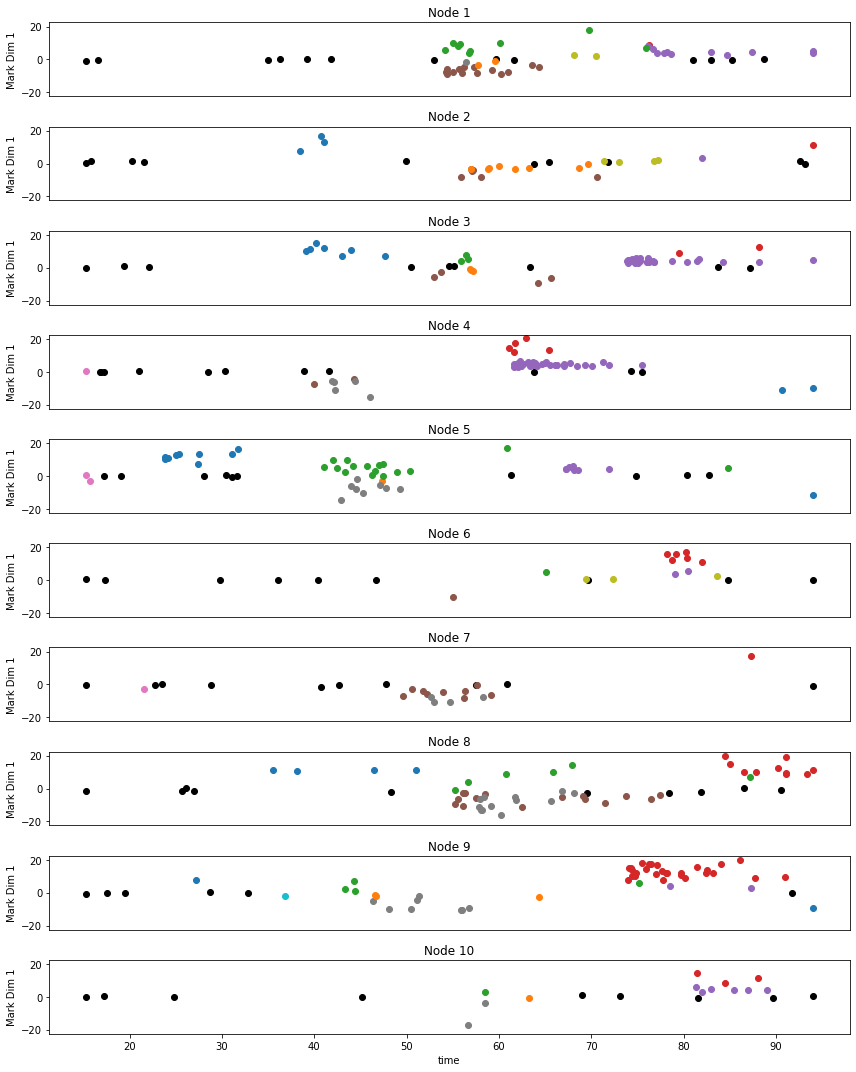

In [60]:
plt.figure(figsize=(12, 15))
ylim = 1.1 * abs(marks[:, 0]).max()
for m in range(M):
    plt.subplot(M, 1, m+1)
    for z in np.unique(parents):
        inds = np.where((parents == z) & (nodes == m))[0]
        plt.plot(times[inds], marks[inds, 0], 'o' if z >= 0 else 'ko')
    
    plt.ylabel("Mark Dim 1")
    plt.ylim(-ylim, ylim)
    if m == M-1:
        plt.xlabel("time")
    else:
        plt.xticks([])
        
    plt.title("Node {}".format(m+1))

plt.tight_layout()

# Fit the correct model to the data

In [61]:
correct_model = NeymanScottModel(
    mu, alpha, beta, lmbda0, 
    bkgd_class(**bkgd_hypers), 
    DefaultClusterFactory(cluster_class, cluster_hypers))

# Fit the model
print("true num clusters: ", M_true)

# samples = correct_model.fit(data, method="mcem", step_size=0.75, num_iters=50, verbose=True)
samples = correct_model.fit(data, method="gibbs", num_samples=100)

# Extract the number of clusters for each sample
t_samples = np.array([s["num_clusters"] for s in samples])

# Permute the sampled parents to match the true ones
inferred_parents = [permute_to_match(parents, s["parents"]) for s in samples]

true num clusters:  13


precomputing log_Vs


num clusters:  12  lp:  -5833.577797799619
num clusters:  14  lp:  -5077.93770833552
num clusters:  15  lp:  -4684.701697832596
num clusters:  14  lp:  -4410.056966359265
num clusters:  15  lp:  -4295.059584239342
num clusters:  14  lp:  -4238.679677074767
num clusters:  13  lp:  -4185.193642023438
num clusters:  13  lp:  -4081.743466311664
num clusters:  13  lp:  -4048.576099161709
num clusters:  14  lp:  -4035.926576712131
num clusters:  14  lp:  -4009.7454626639715
num clusters:  14  lp:  -4003.8684062443745
num clusters:  14  lp:  -3931.962780567091
num clusters:  14  lp:  -3898.9271260850355
num clusters:  15  lp:  -3859.8595452628647
num clusters:  14  lp:  -3865.466790362472
num clusters:  14  lp:  -3858.8278756262303
num clusters:  14  lp:  -3825.592344268595
num clusters:  15  lp:  -3768.829980310128
num clusters:  14  lp:  -3801.553145035502
num clusters:  14  lp:  -3780.7139992761845
num clusters:  14  lp:  -3785.0248406286837
num clusters:  14  lp:  -3767.6681818396264
num 

In [62]:
print(true_model.background.mark_backgrounds[0].mu)
print(correct_model.background.mark_backgrounds[0].mu)

[-0.22028215  0.24346941 -0.02559809 -0.03712666  0.19685901]
[ 0.00312941  0.15471027  0.2472844  -0.0319041   0.06879431]


Text(0.5, 0, 'Event Index (sorted by time)')

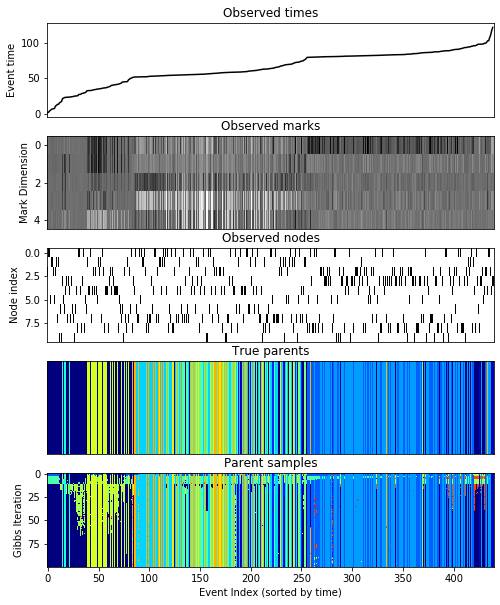

In [63]:
plt.figure(figsize=(8, 10))

plt.subplot(511)
plt.plot(times, '-k')
plt.title("Observed times")
plt.xticks([])
plt.ylabel("Event time")
plt.xlim(0, len(times))

plt.subplot(512)
plt.imshow(marks.T, aspect="auto", cmap="Greys")
plt.title("Observed marks")
plt.xticks([])
plt.ylabel("Mark Dimension")

plt.subplot(513)
plt.imshow(onehot(nodes[:, None], M).T, aspect="auto", cmap="Greys")
plt.title("Observed nodes")
plt.xticks([])
plt.ylabel("Node index")

plt.subplot(514)
plt.imshow(parents[None, :], cmap="jet", aspect="auto", vmax=np.array(inferred_parents).max())
plt.title("True parents")
plt.xticks([])
plt.yticks([])

plt.subplot(515)
plt.imshow(inferred_parents, cmap="jet", aspect="auto", vmax=np.array(inferred_parents).max())
plt.title("Parent samples")
plt.ylabel("Gibbs Iteration")
plt.xlabel("Event Index (sorted by time)")

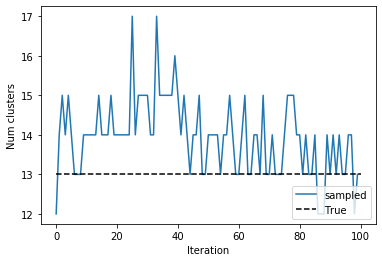

In [64]:
# Plot the number of clusters over samples
plt.figure()
plt.plot([s["num_clusters"] for s in samples], label="sampled")
plt.plot([0, len(samples)], [len(clusters), len(clusters)], '--k', label="True")
plt.xlabel("Iteration")
plt.ylabel("Num clusters")
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'inferred parent')

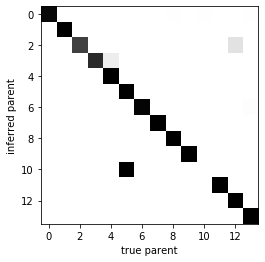

In [65]:
ovlp, rows, cols = compute_state_overlap(parents, inferred_parents[-1])
norm_ovlp = ovlp / ovlp.sum(axis=0, keepdims=True)
plt.imshow(norm_ovlp.T, aspect="equal", cmap="Greys")
plt.xlabel("true parent")
plt.ylabel("inferred parent")

# Compare to a model with no background

In [66]:
nobkgd_model = NeymanScottModel(
        mu, alpha, beta, 1e-8, 
        bkgd_class(**bkgd_hypers), 
        DefaultClusterFactory(cluster_class, cluster_hypers))

# Fit the model
# samples = correct_model.fit(data, method="mcem", step_size=0.75, num_iters=50, verbose=True)
nobkgd_samples = nobkgd_model.gibbs_sample_posterior(data, num_samples=100, init_method="prior")

# Extract the number of clusters for each sample
nobkgd_t_samples = np.array([s["num_clusters"] for s in nobkgd_samples])

# Permute the sampled parents to match the true ones
nobkgd_parents = [permute_to_match(parents, s["parents"][perm]) for s in nobkgd_samples]

precomputing log_Vs


Gibbs sampling event parents


num clusters:  28  lp:  -4323.68776786577
num clusters:  29  lp:  -3748.985097786944
num clusters:  26  lp:  -3686.9179788368356
num clusters:  24  lp:  -3683.161567703784
num clusters:  24  lp:  -3700.249584182428
num clusters:  23  lp:  -3728.472387817403
num clusters:  24  lp:  -3688.2781414815236
num clusters:  21  lp:  -3753.091274142412
num clusters:  20  lp:  -3753.0856655736984
num clusters:  22  lp:  -3707.421956793213
num clusters:  19  lp:  -3765.36960102222
num clusters:  20  lp:  -3763.3369037960256
num clusters:  21  lp:  -3751.698093215774
num clusters:  21  lp:  -3727.277328773333
num clusters:  21  lp:  -3725.568136678694
num clusters:  23  lp:  -3672.9736995432904
num clusters:  22  lp:  -3680.4714502233965
num clusters:  21  lp:  -3699.869224902372
num clusters:  22  lp:  -3694.6275480684676
num clusters:  20  lp:  -3763.1070968428558
num clusters:  21  lp:  -3723.1333759908616
num clusters:  20  lp:  -3756.863443732774
num clusters:  20  lp:  -3755.6090760958305
num

Text(0, 0.5, 'inferred parent')

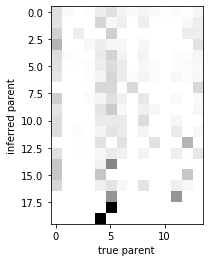

In [67]:
ovlp, rows, cols = compute_state_overlap(parents, nobkgd_parents[-1])
norm_ovlp = ovlp / ovlp.sum(axis=0, keepdims=True)
plt.imshow(norm_ovlp.T, aspect="equal", cmap="Greys")
plt.xlabel("true parent")
plt.ylabel("inferred parent")

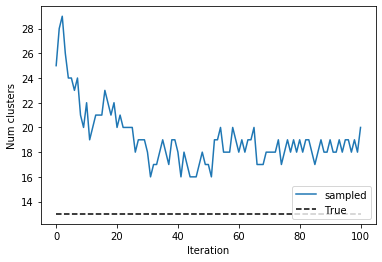

In [68]:
# Plot the number of clusters over samples
plt.figure()
plt.plot([s["num_clusters"] for s in nobkgd_samples], label="sampled")
plt.plot([0, len(samples)], [len(clusters), len(clusters)], '--k', label="True")
plt.xlabel("Iteration")
plt.ylabel("Num clusters")
plt.legend(loc="lower right")
plt.show()

# Compare to a model with misspecified cluster observations

In [69]:
dumbmark_model = NeymanScottModel(
    mu, alpha, beta, lmbda0, 
    GaussianBackground(data_dim=M+1+data_dim), 
    DefaultClusterFactory(
        GaussianCluster, 
        dict(mu0=np.zeros(M+1+data_dim),
             lmbda=1,
             Psi=(M + data_dim + 1) * np.eye(M + data_dim + 1),
             nu=M+data_dim+2)
    )
)

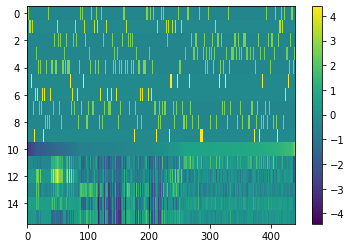

In [72]:
# zscore = lambda x: (x - x.mean()) / x.std()
dumbmark_data = np.column_stack((onehot(nodes[:, None], M), times, marks))
dumbmark_data -= dumbmark_data.mean(axis=0)
dumbmark_data /= dumbmark_data.std(axis=0)

plt.imshow(dumbmark_data.T, aspect="auto")
plt.colorbar()

In [73]:
# Fit the model
# samples = correct_model.fit(data, method="mcem", step_size=0.75, num_iters=50, verbose=True)
dumbmark_samples = dumbmark_model.fit(dumbmark_data, method="gibbs", num_samples=100, init_method="prior")

# Permute the sampled parents to match the true ones
dumbmark_parents = [permute_to_match(parents, s["parents"]) for s in dumbmark_samples]

num clusters:  10  lp:  -2992.1497324869392
num clusters:  4  lp:  -2010.0531676626483
num clusters:  3  lp:  -1095.2257732753435
num clusters:  3  lp:  -951.7743423003172
num clusters:  3  lp:  -964.8334479878401
num clusters:  2  lp:  -1087.062316290086
num clusters:  2  lp:  -1068.5306256079716
num clusters:  2  lp:  -1038.5461164007731
num clusters:  2  lp:  -1074.803245782461
num clusters:  2  lp:  -949.890313221799
num clusters:  2  lp:  -990.3275902968049
num clusters:  2  lp:  -1014.4150661122576
num clusters:  2  lp:  -965.4468917738895
num clusters:  2  lp:  -1009.7866448214153
num clusters:  2  lp:  -960.2017491151277
num clusters:  2  lp:  -988.8413698396789
num clusters:  2  lp:  -978.9776970205254
num clusters:  2  lp:  -970.2422903074475
num clusters:  2  lp:  -986.7937635615939
num clusters:  2  lp:  -963.5292894397836
num clusters:  2  lp:  -1039.7908419865164
num clusters:  2  lp:  -1008.7486033723616
num clusters:  2  lp:  -987.8390554174354
num clusters:  2  lp:  -9

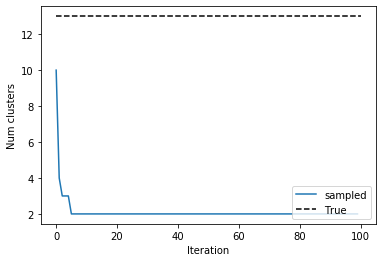

In [74]:
# Plot the number of clusters over samples
plt.figure()
plt.plot([s["num_clusters"] for s in dumbmark_samples], label="sampled")
plt.plot([0, len(samples)], [len(clusters), len(clusters)], '--k', label="True")
plt.xlabel("Iteration")
plt.ylabel("Num clusters")
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'inferred parent')

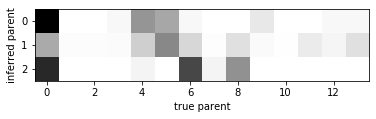

In [75]:
ovlp, rows, cols = compute_state_overlap(parents, dumbmark_parents[-1])
norm_ovlp = ovlp / ovlp.sum(axis=0, keepdims=True)
plt.imshow(norm_ovlp.T, aspect="equal", cmap="Greys")
plt.xlabel("true parent")
plt.ylabel("inferred parent")

# Fit Gaussian mixture on the dumb mark data

In [76]:
from sklearn.mixture import GaussianMixture
km = GaussianMixture(M_true + 1)
km.fit(dumbmark_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=14, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [77]:
km_parents = km.predict(dumbmark_data).astype(int)

In [78]:
km_parents = permute_to_match(parents, km_parents)

Text(0, 0.5, 'inferred parent')

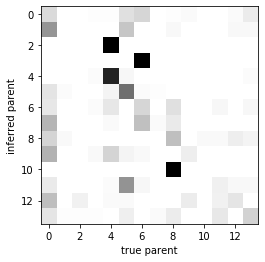

In [79]:
ovlp, rows, cols = compute_state_overlap(parents, km_parents)
norm_ovlp = ovlp / ovlp.sum(axis=0, keepdims=True)
plt.imshow(norm_ovlp.T, aspect="equal", cmap="Greys")
plt.xlabel("true parent")
plt.ylabel("inferred parent")

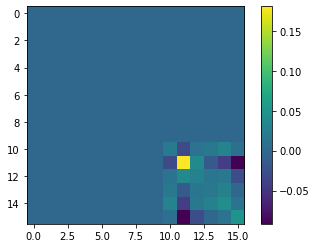

In [100]:
plt.imshow(np.cov(dumbmark_data[km_parents==1].T))
plt.colorbar()

# Make a figure comparing the inferred clusters 

Text(0.5, 0, 'Event Index (sorted by time)')

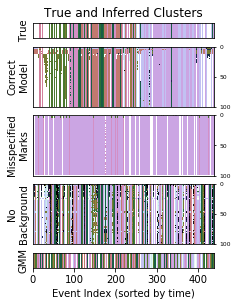

In [80]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(5, 1, height_ratios=[1, 4, 4, 4, 1])
plt.figure(figsize=(3.25, 4.5))

# plt.subplot(511)
# plt.plot(times, '-k')
# plt.title("Observed times")
# plt.xticks([])
# plt.ylabel("Event time")
# plt.xlim(0, len(times))

# plt.subplot(gs[0])
# plt.imshow(marks.T, aspect="auto", cmap="Greys")
# # plt.title("Observed marks")
# plt.xticks([])
# plt.ylabel("Marks")

# plt.subplot(gs[1])
# plt.imshow(onehot(nodes[:, None], M).T, aspect="auto", cmap="Greys")
# # plt.title("Observed nodes")
# plt.xticks([])
# plt.ylabel("Nodes")

plt.subplot(gs[0])
plt.imshow(parents[None, :], cmap="cubehelix_r", aspect="auto", vmax=np.array(inferred_parents).max())
plt.ylabel("True")
plt.title("True and Inferred Clusters")
plt.xticks([])
plt.yticks([])

ax1 = plt.subplot(gs[1])
plt.imshow(inferred_parents, cmap="cubehelix_r", aspect="auto", vmax=np.array(inferred_parents).max())
# plt.title("Neyman-Scott: Collabsed Gibbs Samples")
plt.ylabel("Correct\nModel")
plt.xticks([])
plt.yticks([0, 50, 100])
ax1.yaxis.tick_right()
ax1.tick_params(labelsize=6, length=2)
# plt.xlabel("Event Index (sorted by time)")

ax2 = plt.subplot(gs[2])
plt.imshow(dumbmark_parents, cmap="cubehelix_r", aspect="auto", vmax=np.array(inferred_parents).max())
plt.ylabel("Misspecified\nMarks")
# plt.ylabel("Gibbs Iteration")
plt.xticks([])
plt.yticks([0, 50, 100])
ax2.yaxis.tick_right()
ax2.tick_params(labelsize=6, length=2)
# plt.xlabel("Event Index (sorted by time)")

ax3 = plt.subplot(gs[3])
plt.imshow(nobkgd_parents, cmap="cubehelix_r", aspect="auto", vmax=np.array(inferred_parents).max())
plt.ylabel("No\nBackground")
plt.yticks([])
plt.yticks([0, 50, 100])
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=6, length=2)
plt.xticks([])
# plt.xlabel("Event Index (sorted by time)")


plt.subplot(gs[4])
plt.imshow(km_parents[None,:], cmap="cubehelix_r", aspect="auto", vmax=np.array(inferred_parents).max())
# plt.title("K-Means")
plt.ylabel("GMM")
plt.yticks([])
plt.xlabel("Event Index (sorted by time)")

# plt.savefig("synth1.pdf")